# Titanic 생존자 예측 예제


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
titanic=pd.read_csv('C:/Users/admin/dataset/titanic_train.csv')

In [3]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1. Data의 information 확인
### (1) 전체 정보 확인
- RangeIndex
    - DataFrame의 Index의 범위 나타냄
    - 전체 row수 알 수 있음
    

In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Titanic Data 정보 
- RangeIndex=891 이므로 데이터는 총 891개
- Age, Cabin, Embarked에 null값이 존재함을 알 수 있음

## 2. 결측치 처리
- 머신러닝 알고리즘은 Null값 허용하지 X
- fillna() 함수 사용
- Age => 평균 , Cabin & Embarked => 'N' 으로 변경하기

In [7]:
# Age => 평균
titanic['Age'].fillna(titanic['Age'].mean(), inplace=True)

In [9]:
# Cabin & Embarked => 'N' 으로 변경
titanic['Cabin'].fillna('N',inplace=True)
titanic['Embarked'].fillna('N', inplace=True)

In [10]:
# column별 null값의 갯수
titanic.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

## 3. Feature 확인
### (1) 문자열 Feature의 분포

In [11]:
# Sex 값의 분포
titanic['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [12]:
# Cabin 값의 분포
titanic['Cabin'].value_counts()

N              687
G6               4
C23 C25 C27      4
B96 B98          4
D                3
              ... 
A32              1
A24              1
D37              1
C90              1
D46              1
Name: Cabin, Length: 148, dtype: int64

In [13]:
# Embarked 값의 분포
titanic['Embarked'].value_counts()

S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64

### Result
- Sex, Embarked 값은 문제 X
- Cabin의 경우 
    - 결측값 (N)이 687건으로 매우 많음
    - 'C23 C25 C27' 처럼 여러 Cabin이 한꺼번에 표기된게 많음
    - 선실 등급을 나타내는 알파벳이 중요해보임   
    => 앞글자만 추출하기

In [15]:
# Cabin의 앞글자만 추출
titanic['Cabin']=titanic['Cabin'].str[:1]

In [16]:
titanic['Cabin'].head()

0    N
1    C
2    N
3    C
4    N
Name: Cabin, dtype: object

## 4. Data 탐색
### (1) 성별에 따른 생존자 수 비교

In [21]:
titanic.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

### Result
- 0 : 사망 , 1: 생존
- 탑승객의 경우 남성이 여성보다 많음
- 여성의 경우 314명 중 233명이 살아남아 74.2%가 생존
- 남성의 경우 577명 중 109명이 살아남아 18.8%가 생존

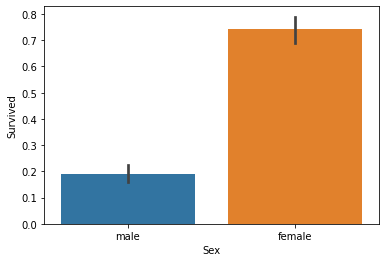

In [23]:
sns.barplot(x='Sex', y='Survived', data=titanic)

### (2) 소득별 생존률 비교
- 부를 측정할 수 있는 속성인 'Pclass"이용
- 객실 등급 별 성별에 따른 생존 확률 막대 그래프로 표현

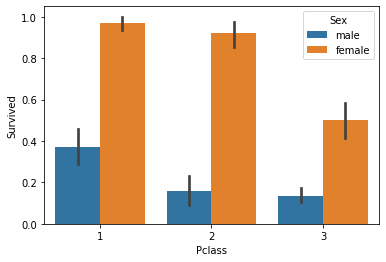

In [26]:
sns.barplot(x="Pclass", y="Survived",hue="Sex", data=titanic)

### Result 
- 여성의 경우
    - 1,2등실에 따른 생존 확률의 차이 크지 않음
    - 3등실의 경우 생존확률이 상대적으로 많이 떨어짐
- 남성의 경우
    - 1등실의 생존 확률이 2,3등실의 생존 확률보다 월등히 높음

### (3) Age에 따른 생존 확률
- 연속형 값을 가지고 있기 때문에 범주형으로 변경
- 0~5 : baby , 6~12 : Child , 13~18 :Teenager, 19~25 : Student ,   
  26~35: Young Adult , 36~60:Adult, 61~ : Elderly,  
  -1이하의 오류값 : Unknown

In [27]:
# age에 따라 구분값을 반환
def get_category(age):
    ans=""
    if age<=-1: ans="Unknown"
    elif age<=5: ans="baby"
    elif age<=12: ans="child"
    elif age<=18: ans="Teenager"
    elif age<=25: ans="Student"
    elif age<=35: ans="Young Adult"
    elif age<=60: ans="Adult"
    else: ans="Elderly"
    return ans

In [28]:
titanic['newAge']=titanic['Age'].apply(lambda x: get_category(x))

In [29]:
titanic.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,newAge
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,N,S,Student
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Adult


In [42]:
# 막대그래프로 확인
# x축의 값 (이 순서대로 그래프를 정렬하기 위함 )
group_names=['Unknow', 'baby','child', 'Teenager', 'Student','Young Adult', 'Adult' , 'Elderly']

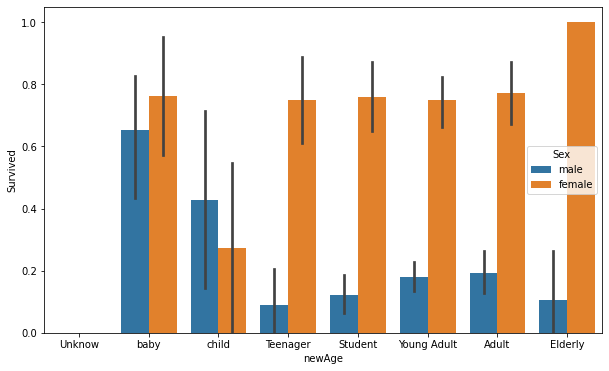

In [43]:
plt.figure(figsize=(10,6))
sns.barplot(x='newAge',y='Survived', hue='Sex',data=titanic, order=group_names )

### Result
- 여자 baby의 경우 비교적 생존 확률이 높으나 child의 경우 생존확률이 낮음
- 여자 Elderly의 경우 생존확률이 매우 높았음

### 전체 결과
- Sex, Age, PClass가 생존률에 영향을 미치는 feature임을 알 수 있음 

## 5. 문자열 Feature를 숫자형 Feature로 변환
### LabelEncoder 사용
- category 값의 유형에 따라 숫자로 변환

In [13]:
from sklearn import preprocessing

In [45]:
# 한번에 label encoding위한 함수
def encode_features(dataDF):
    features=['Cabin','Sex','Embarked']
    for f in features:
        le=preprocessing.LabelEncoder()
        le=le.fit(dataDF[f])
        dataDF[f]=le.transform(dataDF[f])
    return dataDF

In [46]:
titanic=encode_features(titanic)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,newAge
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3,Student
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0,Adult
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3,Young Adult
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3,Young Adult


## * 정리 *
- feature 가공한 내역들을 정리 
- 함수로 만들어서 재사용 하기 위함

In [4]:
# null처리
def fillnan(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

In [5]:
# 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name', 'Ticket'], axis=1,inplace=True)
    return df

In [6]:
# Label Encoding 수행
def format_features(df):
    df['Cabin']=df['Cabin'].str[:1]
    features=['Cabin', 'Sex','Embarked']
    for f in features:
        le=preprocessing.LabelEncoder()
        le=le.fit(df[f])
        df[f]=le.transform(df[f])
    return df

In [7]:
# 앞에서 설정한 데이터 전처리 함수 호출( 전체 )
def transform_features(df):
    df=fillnan(df)
    df=drop_features(df)
    df=format_features(df)
    return df

## 예제 다시 시작하기 (함수 사용)
### (1) x,y값 추출 

In [15]:
dt=pd.read_csv('C:/Users/admin/dataset/titanic_train.csv')

In [16]:
y_dt=dt['Survived']
x_dt=dt.drop('Survived', axis=1)

### (2) 데이터 가공하기

In [17]:
x_dt=transform_features(x_dt)

In [18]:
x_dt.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.0,1,0,7.2500,7,3
1,1,0,38.0,1,0,71.2833,2,0
2,3,0,26.0,0,0,7.9250,7,3
3,1,0,35.0,1,0,53.1000,2,3
4,3,1,35.0,0,0,8.0500,7,3


### (3) train / test data로 나누기
- test는 20%로 설정

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test=train_test_split(x_dt,y_dt,test_size=0.2, random_state=11)

### (4) Modeling & Predict Accuracy

In [20]:
from sklearn.metrics import accuracy_score

In [21]:
# 1. 결정 트리 (DecisionTree)
from sklearn.tree import DecisionTreeClassifier
df_clf=DecisionTreeClassifier(random_state=11)


In [22]:
# DecisionTree 학습 & 예측 
df_clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=11, splitter='best')

In [23]:
df_pred=df_clf.predict(X_test)
accuracy_score(y_test,df_pred)

0.7877094972067039

In [24]:
# 2. Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf=RandomForestClassifier(random_state=11)

In [25]:
# 2. Random Forest 학습 & 예측 
rf_clf.fit(X_train,y_train)
rf_pred=rf_clf.predict(X_test)
accuracy_score(y_test,rf_pred)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8324022346368715

In [26]:
# 3. 로지스틱 회귀 (Logistic Regression)
from sklearn.linear_model import LogisticRegression
lr_clf=LogisticRegression()

In [27]:
# Logistic Regression 학습 & 예측 & 평가
lr_clf.fit(X_train, y_train)
lr_pred=lr_clf.predict(X_test)
accuracy_score(y_test, lr_pred)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8659217877094972

### Result
- Logistic Regression이 높은 정확도 가짐
- 최적화 작업 수행하지 X, 데이터 양이 적기때문에 성능을 평가할 수 없음 

## 교차검증으로 Decision Tree 평가하기
### (1) K Fold 이용해 교차 검증  
- 폴드 갯수 5개

In [30]:
from sklearn.model_selection import KFold

def exec_kfold(clf,folds=5):
    # fold set을 5개인 KFold객체 생성
    # fold수만큼 예측 결과 저장 위한 list 객체 생성 
    kfold=KFold(n_splits=folds)
    scores=[]

    # k fold 교차검증 수행
    for iter_count,(train_idx,test_idx) in enumerate(kfold.split(x_dt)):
        # x_dt 에서 교차 검증 별로 학습 & 검증 데이터 가르키는 idx생성
        X_train,X_test=x_dt.values[train_idx], x_dt.values[test_idx]
        y_train,y_test=y_dt.values[train_idx], y_dt.values[test_idx]
        # Classifier 학습 , 예측 , 정확도 계산
        clf.fit(X_train,y_train)
        predictions=clf.predict(X_test)
        accuracy=accuracy_score(y_test,predictions)
        scores.append(accuracy)
    # 5개 fold에서 평균 
    mean_score=np.mean(scores)
    return mean_score

In [31]:
exec_kfold(df_clf,folds=5)

0.782298662984119

### Result
- 평균 정확도는 78.23%

### (2) cross_val_score() 이용해 교차검증
- Stratified K 폴드 방식

In [32]:
from sklearn.model_selection import cross_val_score

In [33]:
scores=cross_val_score(df_clf, x_dt, y_dt, cv=5)
np.mean(scores)

0.7835081515022234

### (3) GridSearchCV
- cv=5
- Hyper parameter => max_depth, min_samples_split, min_samples_leaf 바꾸면서 성능 측정


In [36]:
from sklearn.model_selection import GridSearchCV

parameter={'max_depth': [2,3,5,10], 'min_samples_split': [2,3,5], 'min_samples_leaf': [1,5,8]}
grid_dclf=GridSearchCV(df_clf, param_grid=parameter, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=11,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [2, 3, 5, 10],
                         'min_samples_leaf': [1, 5, 8],
                         'min

In [37]:
# 최적 하이퍼 파라미터
grid_dclf.best_params_

{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

In [38]:
# 그때의 예측 출력 (최고 정확도 )
grid_dclf.best_score_

0.7991573033707865

In [39]:
best_dclf= grid_dclf.best_estimator_

In [40]:
# GridSearchCV의 최적 파라미터로 학습된 Estimator로 예측 및 평가 수행
dpredictions=best_dclf.predict(X_test)
accuracy=accuracy_score(y_test,dpredictions)
accuracy

0.8715083798882681

### Result
- max_depth =3 , min_samples_split =1 , min_samples_leaf=2 로 학습시켰을 때 정확도가 87.15%로 향상 
- 하이퍼 파라미터 변경 전보다 8% 이상 증가했음 
    - 데이터가 작기때문에 이런 결과 나옴
    - 실제로는 이런 결과 나오지 않음 
    

## TIP
- 머신러닝 모델은 학습 data set으로 학습 뒤 별도의 test set으로 평가해야함
- test data의 건수 부족 & 고정된 test data를 이용한 반복적인 모델의 학습, 평가는 해당 test data에서만 치우친 빈약한 머신러닝 모델 만듬
    - 이를 방지하기 위해 교차검증 수행